# Neural Time Series Forecasting 

This project tackles multi-step forecasting of univariate time series generated by different underlying processes. We build and train a GRU + Conv1D neural model to predict future trajectories, significantly outperforming simple baseline predictors.


## 1. Setup and imports

We start by fixing the random seed for reproducibility and importing the main libraries:
- `numpy`, `pandas`, `matplotlib`, `seaborn` for data handling and visualisation
- `tensorflow.keras` for building and training the neural network
- `sklearn` for train/validation/test splitting and preprocessing


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import TensorFlow / Keras and configure logging
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


## 2. Load and preprocess the data

We load:
- `training_data.npy`: list of time series
- `categories.npy`: class label for each time series (6 underlying processes)
- `valid_periods.npy`: valid index ranges for each series

We then:
- restrict each series to its valid interval
- filter out very short sequences
- prepare a clean dataset for sequence building.

In [ ]:
dataset = np.load('training_data.npy')
label = np.load('categories.npy')
valid = np.load('valid_periods.npy')

In [ ]:
# Contains the sliced rows
valid_dataset = []

for i,v in enumerate(valid):
    start = v[0]
    end = v[1]
    valid_dataset.append(dataset[i][start:end+1])  # +1 to include the 'end' index

# Convert the list of valid rows back to a NumPy array
valid_dataset = np.array(valid_dataset)

valid_dataset.shape, label.shape

((48000,), (48000,))

### 2.1 Filter out short time series

We discard or truncate series that are too short for our chosen input window (`window = 200`) and forecasting horizon (`telescope`), in order to:

- reduce the amount of padding,
- avoid sequences with too little information,
- keep the dataset as homogeneous as possible.


In [ ]:
# Get the unique values and their counts
value_counts = {value: np.count_nonzero(label == value) for value in np.unique(label)}
tmp_size = len(label)
# Print the results
for value, count in value_counts.items():
    print(f"{value} appears {count} time(s)")

A appears 5728 time(s)
B appears 10987 time(s)
C appears 10017 time(s)
D appears 10016 time(s)
E appears 10975 time(s)
F appears 277 time(s)


In [ ]:
limit = 200

In [ ]:
reduced_valid_dataset = []
reduced_labels = []
for i,v in enumerate(valid_dataset):
  if len(v) >= limit:# or label[i]=='B':
    reduced_valid_dataset.append(v)
    reduced_labels.append(label[i])
valid_dataset = np.array(reduced_valid_dataset)
label = np.array(reduced_labels)
valid_dataset.shape, label.shape

((23057,), (23057,))

In [ ]:
# Get the unique values and their counts
value_counts = {value: np.count_nonzero(label == value) for value in np.unique(label)}
tmp_size_2 = len(label)
# Print the results
for value, count in value_counts.items():
    print(f"{value} appears {count} time(s)")

A appears 4088 time(s)
B appears 3671 time(s)
C appears 5282 time(s)
D appears 5633 time(s)
E appears 4263 time(s)
F appears 120 time(s)


## 3. Build input–output sequences

We convert each variable-length time series into multiple fixed-length sequences:

- each input window has length `window` (e.g. 200 samples),
- each target vector contains the next `telescope` samples (e.g. 18 steps ahead),
- we slide a window with stride `stride` and collect all valid (input, output) pairs.

This function returns:
- `X`: array of input windows,
- `y`: array of corresponding future trajectories,
- `cat`: class label for each window.


In [ ]:
window = 200
stride = 20
telescope = 18

In [ ]:
def build_sequences(valid_dataset = valid_dataset, categories = label, window=window, stride=stride, telescope=telescope):
assert window % stride == 0, "Window length should be a multiple of stride."

    X = []              # input windows (seen part)
    y = []              # target sequences (unseen part)
    new_categories = [] # category per window

    for i, series in enumerate(valid_dataset):
        temp = np.array(series)

        # Ignore the tail that would be used as target
        effective_length = len(temp) - telescope

        # If the effective length is below the window, pad up to `window`
        if effective_length < window:
            pad_len = window - effective_length
            temp = np.concatenate([temp, np.repeat(temp[-1], pad_len)])
            effective_length = len(temp) - telescope

        # Ensure the remaining length is compatible with the chosen stride
        assert effective_length % stride == 0

        # Slide the window and build (input, output) pairs
        for idx in np.arange(0, len(temp) - window - telescope + 1, stride):
            X.append(temp[idx : idx + window])
            y.append(temp[idx + window : idx + window + telescope])
            new_categories.append(categories[i])

    X = np.array(X)
    y = np.array(y)
    new_categories = np.array(new_categories)

    return X, y, new_categories

In [ ]:
X, y, cat = build_sequences()
X.shape, y.shape, cat.shape

((126635, 200), (126635, 18), (126635,))

## 4. Train / validation / test split

We split the data into:
- train
- validation
- test

using stratified splitting on the class label to preserve the class distribution across all sets.


In [ ]:
# Dataframes with a time series per each row
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [ ]:
# Add category column
X['category'] = cat
y['category'] = cat

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    stratify = X['category'],
    random_state = seed
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test),
    stratify = X_train_val['category'],
    random_state = seed,
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((101307, 201), (12664, 201), (101307, 19), (12664, 19))

In [ ]:
# Deleting the column "category"
X_test_categories = X_test['category'].to_numpy()
X_train = X_train.drop('category', axis=1)
X_val = X_val.drop('category', axis=1)
X_test = X_test.drop('category', axis=1)

y_train = y_train.drop('category', axis=1)
y_val = y_val.drop('category', axis=1)
y_test = y_test.drop('category', axis=1)

In [ ]:
# Expanding 1 dimension
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((101307, 200, 1),
 (101307, 18, 1),
 (12664, 200, 1),
 (12664, 18, 1),
 (12664, 200, 1),
 (12664, 18, 1))

## 5. Model definition and training

We define a GRU + Conv1D architecture and train it using:
- Mean Squared Error (MSE) loss
- Adam optimizer
- EarlyStopping and ReduceLROnPlateau on the validation loss

We also save the best model weights using ModelCheckpoint.


In [ ]:
input_shape = X_train_val.shape[1:]
output_shape = y_train_val.shape[1:]
batch_size = 128
epochs = 400

In [ ]:
def build_CONV_GRU_DENSE_model(input_shape, output_shape):
    assert input_shape[0] >= output_shape[0], \
        "For this exercise we want input time steps to be >= output time steps."

    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Bidirectional GRU to capture temporal dependencies
    x = tfkl.Bidirectional(
        tfkl.GRU(32, return_sequences=True, name='gru'),
        name='bidirectional_gru'
    )(inputs)

    # 1D convolution to extract local patterns in the hidden states
    x = tfkl.Conv1D(64, 3, padding='same', activation='gelu', name='conv1')(x)

    # Global pooling + dense projection to the forecasting horizon
    x = tfkl.GlobalAveragePooling1D()(x)
    x = tfkl.Flatten()(x)
    outputs = tfkl.Dense(output_shape[0], activation='relu')(x)
    outputs = tfkl.Reshape(output_shape)(outputs)

    model = tfk.Model(inputs=inputs, outputs=outputs, name='CONV_GRU_DENSE_model')
    model.compile(
        loss=tfk.losses.MeanSquaredError(),
        optimizer=tfk.optimizers.Adam()
    )
    return model

Model: "CONV_GRU_DENSE_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_gru (Bidirec  (None, 200, 64)           6720      
 tional)                                                         
                                                                 
 conv2 (Conv1D)              (None, 200, 64)           12352     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 18)       

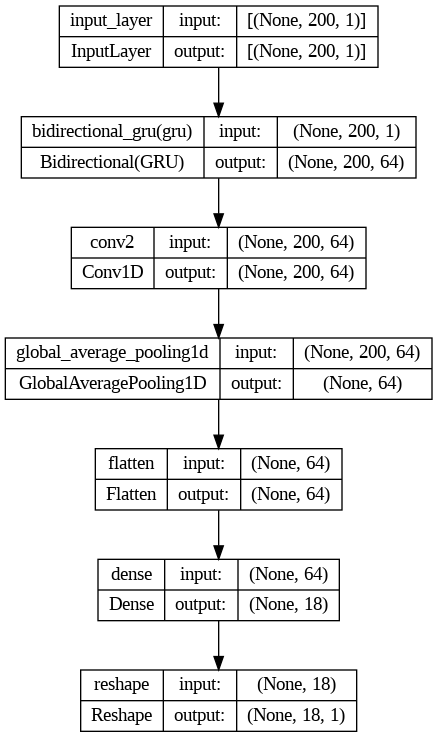

In [ ]:
model = build_CONV_GRU_DENSE_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

### 5.2 Training loop and callbacks


In [ ]:
filepath = 'Model_best_'

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=35, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=35, factor=0.1, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    ]
).history

Epoch 1/400
891/891 [==============================] - ETA: 0s - loss: 0.0712
Epoch 1: val_loss improved from inf to 0.01302, saving model to Conv_GRU32_Dense_Gelu_Limit100_Stride10_NewSequences_Epoch01_Loss0.0130
891/891 [==============================] - 35s 30ms/step - loss: 0.0712 - val_loss: 0.0130 - lr: 0.0010
Epoch 2/400
890/891 [============================>.] - ETA: 0s - loss: 0.0128
Epoch 2: val_loss improved from 0.01302 to 0.01278, saving model to Conv_GRU32_Dense_Gelu_Limit100_Stride10_NewSequences_Epoch02_Loss0.0128
891/891 [==============================] - 25s 28ms/step - loss: 0.0128 - val_loss: 0.0128 - lr: 0.0010
Epoch 3/400
890/891 [============================>.] - ETA: 0s - loss: 0.0127
Epoch 3: val_loss improved from 0.01278 to 0.01242, saving model to Conv_GRU32_Dense_Gelu_Limit100_Stride10_NewSequences_Epoch03_Loss0.0124
891/891 [==============================] - 26s 29ms/step - loss: 0.0127 - val_loss: 0.0124 - lr: 0.0010
Epoch 4/400
890/891 [=================

In [ ]:
# To load a pre-trained model instead of training from scratch:
# model = tfk.models.load_model('Model_best_fancy')

In [1]:
# best_epoch = np.argmin(history['val_loss'])
# plt.figure(figsize=(17,4))
# plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
# plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
# plt.title('Mean Squared Error')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

# plt.figure(figsize=(18,3))
# plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()


## 6. Evaluation on the test set

We evaluate the best model on the test set (telescope = 18) using:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (12664, 18, 1)
Mean Squared Error: 0.007646671496331692
Mean Absolute Error: 0.057307180017232895
